In [1]:
import unicodedata
import re
import json
import os
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import requests
import nltk
from nltk.corpus import stopwords
from time import strftime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

import scipy.stats as stats
from jos_acquire import *
from jos_prepare import *

import warnings
warnings.filterwarnings("ignore")

# Acquire
___

In [2]:
def get_all_repository_urls(url): # repository url
    # Get max page.
    response = get(url)
    soup = BeautifulSoup(response.text)
    print('Finding max page for repositories...')
    max_page = int(soup.find('div', role='navigation').text[-6])
    print(f'Max page found: {max_page}')
    page = 1
    repository_links = []
    print('Starting loop...')
    for n in range(max_page):
        print(n+1, 'iteration')
        print(f'Pulling data from {url}')
        # Reset soup.
        response = get(url)
        soup = BeautifulSoup(response.text)
        # Get all the repositories from the page.
        repositories = soup.find_all('a', itemprop='name codeRepository') 
        print('Fetching links for repositories...')
        for repo in repositories:
            repository_links.append(repo.get('href'))
        git = 'https://github.com/'
        next_page = soup.find('a', class_='next_page').get('href')[:-1]
        ## Use this line of code to get the url for the next page.
        if page <= 4:
            url = git + next_page + str(page + 1)
            page += 1
        else:
            return repository_links

In [3]:
repository_links = get_all_repository_urls('https://github.com/orgs/apple/repositories')

repository_links

Finding max page for repositories...
Max page found: 6
Starting loop...
1 iteration
Pulling data from https://github.com/orgs/apple/repositories
Fetching links for repositories...
2 iteration
Pulling data from https://github.com//orgs/apple/repositories?page=2
Fetching links for repositories...
3 iteration
Pulling data from https://github.com//orgs/apple/repositories?page=3
Fetching links for repositories...
4 iteration
Pulling data from https://github.com//orgs/apple/repositories?page=4
Fetching links for repositories...
5 iteration
Pulling data from https://github.com//orgs/apple/repositories?page=5
Fetching links for repositories...


['/apple/llvm-project',
 '/apple/swift-docc-render',
 '/apple/foundationdb',
 '/apple/swift-nio',
 '/apple/swift-evolution',
 '/apple/swift',
 '/apple/swift-docc',
 '/apple/swift-syntax',
 '/apple/swift-package-manager',
 '/apple/servicetalk',
 '/apple/swift-experimental-string-processing',
 '/apple/swift-tools-support-core',
 '/apple/cups',
 '/apple/swift-format',
 '/apple/swift-collections',
 '/apple/swift-corelibs-libdispatch',
 '/apple/swift-protobuf',
 '/apple/sourcekit-lsp',
 '/apple/swift-argument-parser',
 '/apple/swift-llbuild',
 '/apple/swift-source-compat-suite',
 '/apple/swift-markdown',
 '/apple/swift-docc-symbolkit',
 '/apple/swift-docc-render-artifact',
 '/apple/swift-lmdb',
 '/apple/swift-driver',
 '/apple/indexstore-db',
 '/apple/swift-stress-tester',
 '/apple/swift-xcode-playground-support',
 '/apple/swift-integration-tests',
 '/apple/swift-cmark',
 '/apple/swift-corelibs-foundation',
 '/apple/swift-corelibs-xctest',
 '/apple/swift-docker',
 '/apple/swift-installer-sc

In [4]:
df = pd.read_json('data.json')

df

,repo,language,readme_contents
0,apple/llvm-project,None,# Apple's fork of llvm-project\n\nThis is Appl...
1,apple/swift-argument-parser,Swift,# Swift Argument Parser\n\n## Usage\n\nBegin b...
2,apple/swift-docc,Swift,# Swift-DocC\n\nSwift-DocC is a documentation ...
3,apple/swift,C++,"<img src=""https://swift.org/assets/images/swif..."
4,apple/sourcekit-lsp,Swift,# SourceKit-LSP\n\nSourceKit-LSP is an impleme...
...,...,...,...
146,apple/ccs-caldavclientlibrary,HTML,README for CalDAVClientLibrary\n\nINTRODUCTION...
147,apple/ccs-pyosxframeworks,Python,Getting Started\n===============\n\nThis is a ...
148,apple/ccs-pysecuretransport,Python,Getting Started\n===============\n\nOS X Secur...
149,apple/swift-protobuf-test-conformance,None,"<img src=""https://swift.org/assets/images/swif..."


In [5]:
df.language.value_counts()

Swift               65
Python              38
C++                 15
C                   11
Jupyter Notebook     2
JavaScript           2
HTML                 2
Java                 2
LLVM                 1
Dockerfile           1
Shell                1
R                    1
Markdown             1
Starlark             1
Name: language, dtype: int64

In [6]:
df[df.language.isna()]

,repo,language,readme_contents
0,apple/llvm-project,None,# Apple's fork of llvm-project\n\nThis is Appl...
13,apple/swift-docc-render-artifact,None,# Swift-DocC-Render-Artifact\n\nThis repositor...
14,apple/swift-lmdb,None,# CLMDB\n\nCLMDB is a SwiftPM package wrapper ...
83,apple/swift-community-hosted-continuous-integr...,None,# Swift Community-Hosted Continuous Integratio...
123,apple/ml-transcript-translation-consistency-ra...,None,# Human Ratings of Transcription/Translation C...
139,apple/llvm-monorepo-root,None,# Disclaimer\n\nThe [llvm-monorepo-root](https...
145,apple/swift-protobuf-plugin,None,"<img src=""https://swift.org/assets/images/swif..."
149,apple/swift-protobuf-test-conformance,None,"<img src=""https://swift.org/assets/images/swif..."


Our categories for classification might be Swift, Python, C (with both C & C++), & other. For modeling, we can maybe have a df that is only the languages Swift, Python, and C; that way we still have over 100 values without nulls (shows how I know that below).

In [7]:
cut_df = df.loc[df['language'].isin(['Swift', 'Python', 'C', 'C++'])]
cut_df.shape

(129, 3)

In [8]:
cut_df = cut_df.dropna()
cut_df.shape

(129, 3)

In [9]:
cut_df.language.value_counts()

Swift     65
Python    38
C++       15
C         11
Name: language, dtype: int64

In [10]:
cut_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 1 to 150
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             129 non-null    object
 1   language         129 non-null    object
 2   readme_contents  129 non-null    object
dtypes: object(3)
memory usage: 4.0+ KB


# Prepare
___

#### Need to Clean, Stem, & lemmatize the words

In [11]:
df.shape

(151, 3)

In [12]:
df = df.dropna().reset_index(drop=True)

In [13]:
# Change 'C++' to 'C'
df.loc[df.language == 'C++', 'language'] = 'C'

In [14]:
# Change values of all the other languages to 'Other'
df.loc[df.language.isin(['Swift','Python','C']) == False, 'language'] = 'Other'

df.language.value_counts()

Swift     65
Python    38
C         26
Other     14
Name: language, dtype: int64

In [15]:
# Create a list where there are no readme contents
i = df[df.readme_contents == ''].index
# Drop repos where there is no readme content
df.drop(i, inplace=True)
df

,repo,language,readme_contents
0,apple/swift-argument-parser,Swift,# Swift Argument Parser\n\n## Usage\n\nBegin b...
1,apple/swift-docc,Swift,# Swift-DocC\n\nSwift-DocC is a documentation ...
2,apple/swift,C,"<img src=""https://swift.org/assets/images/swif..."
3,apple/sourcekit-lsp,Swift,# SourceKit-LSP\n\nSourceKit-LSP is an impleme...
4,apple/foundationdb,C,"<img alt=""FoundationDB logo"" src=""documentatio..."
...,...,...,...
136,apple/ml-all-pairs,Python,"<img alt=""All-Pairs example"" src=""examples/all..."
137,apple/swift-3-api-guidelines-review,Swift,# Swift 3 API Guidelines Review\n\nThis reposi...
139,apple/ccs-caldavclientlibrary,Other,README for CalDAVClientLibrary\n\nINTRODUCTION...
140,apple/ccs-pyosxframeworks,Python,Getting Started\n===============\n\nThis is a ...


In [16]:
df.rename(columns={'readme_contents': 'original'}, inplace=True)
df.head()

,repo,language,original
0,apple/swift-argument-parser,Swift,# Swift Argument Parser\n\n## Usage\n\nBegin b...
1,apple/swift-docc,Swift,# Swift-DocC\n\nSwift-DocC is a documentation ...
2,apple/swift,C,"<img src=""https://swift.org/assets/images/swif..."
3,apple/sourcekit-lsp,Swift,# SourceKit-LSP\n\nSourceKit-LSP is an impleme...
4,apple/foundationdb,C,"<img alt=""FoundationDB logo"" src=""documentatio..."


In [17]:
df_prepped = prep_article_data(df, 'original', extra_words = [], exclude_words = [])
df_prepped.head()

,language,original,clean,stemmed,lemmatized
0,Swift,# Swift Argument Parser\n\n## Usage\n\nBegin b...,swift argument parser usage begin declaring ty...,swift argument parser usag begin declar type d...,swift argument parser usage begin declaring ty...
1,Swift,# Swift-DocC\n\nSwift-DocC is a documentation ...,swiftdocc swiftdocc documentation compiler swi...,swiftdocc swiftdocc document compil swift fram...,swiftdocc swiftdocc documentation compiler swi...
2,C,"<img src=""https://swift.org/assets/images/swif...",img srchttpsswiftorgassetsimagesswiftsvg altsw...,img srchttpsswiftorgassetsimagesswiftsvg altsw...,img srchttpsswiftorgassetsimagesswiftsvg altsw...
3,Swift,# SourceKit-LSP\n\nSourceKit-LSP is an impleme...,sourcekitlsp sourcekitlsp implementation langu...,sourcekitlsp sourcekitlsp implement languag se...,sourcekitlsp sourcekitlsp implementation langu...
4,C,"<img alt=""FoundationDB logo"" src=""documentatio...",img altfoundationdb logo srcdocumentationfdblo...,img altfoundationdb logo srcdocumentationfdblo...,img altfoundationdb logo srcdocumentationfdblo...


In [18]:
df_prepped['bigrams'] = [list(pd.Series(list(nltk.ngrams(readme.split(),2)))) for readme in df_prepped.lemmatized]
df_prepped.head()

,language,original,clean,stemmed,lemmatized,bigrams
0,Swift,# Swift Argument Parser\n\n## Usage\n\nBegin b...,swift argument parser usage begin declaring ty...,swift argument parser usag begin declar type d...,swift argument parser usage begin declaring ty...,"[(swift, argument), (argument, parser), (parse..."
1,Swift,# Swift-DocC\n\nSwift-DocC is a documentation ...,swiftdocc swiftdocc documentation compiler swi...,swiftdocc swiftdocc document compil swift fram...,swiftdocc swiftdocc documentation compiler swi...,"[(swiftdocc, swiftdocc), (swiftdocc, documenta..."
2,C,"<img src=""https://swift.org/assets/images/swif...",img srchttpsswiftorgassetsimagesswiftsvg altsw...,img srchttpsswiftorgassetsimagesswiftsvg altsw...,img srchttpsswiftorgassetsimagesswiftsvg altsw...,"[(img, srchttpsswiftorgassetsimagesswiftsvg), ..."
3,Swift,# SourceKit-LSP\n\nSourceKit-LSP is an impleme...,sourcekitlsp sourcekitlsp implementation langu...,sourcekitlsp sourcekitlsp implement languag se...,sourcekitlsp sourcekitlsp implementation langu...,"[(sourcekitlsp, sourcekitlsp), (sourcekitlsp, ..."
4,C,"<img alt=""FoundationDB logo"" src=""documentatio...",img altfoundationdb logo srcdocumentationfdblo...,img altfoundationdb logo srcdocumentationfdblo...,img altfoundationdb logo srcdocumentationfdblo...,"[(img, altfoundationdb), (altfoundationdb, log..."


# Explore
___

In [19]:
# Create a corpus of words for each category.
swift_words = ' '.join(df_prepped[df_prepped.language == 'Swift'].lemmatized)
c_words = ' '.join(df_prepped[df_prepped.language == 'C'].lemmatized)
python_words = ' '.join(df_prepped[df_prepped.language == 'Python'].lemmatized)
other_words = ' '.join(df_prepped[df_prepped.language == 'Other'].lemmatized)

swift_bigrams = pd.Series(list(nltk.ngrams(swift_words.split(), 2)))
c_bigrams = pd.Series(list(nltk.ngrams(c_words.split(), 2)))
python_bigrams = pd.Series(list(nltk.ngrams(python_words.split(), 2)))
other_bigrams = pd.Series(list(nltk.ngrams(other_words.split(), 2)))

In [20]:
# Top 10 words for 'Swift'
pd.Series(swift_words.split()).value_counts().head(10)

swift         772
'             368
package       301
use           216
project       213
library       207
using         183
build         172
dependency    150
type          145
dtype: int64

In [21]:
# Top 10 words for 'C'
pd.Series(c_words.split()).value_counts().head(10)

build      157
swift      119
file        95
kernel      73
use         70
make        66
code        65
support     60
crypto      49
project     46
dtype: int64

In [22]:
# Top 10 words for 'Python'
pd.Series(python_words.split()).value_counts().head(10)

&#9;       1574
'           379
python      158
file        129
dataset     123
data        122
model       118
element     108
test        107
use          94
dtype: int64

In [23]:
# Top 10 words for 'Other'
pd.Series(other_words.split()).value_counts().head(20)

'                84
password         53
swift            36
website          28
project          27
tensorflow       25
user             23
use              23
run              23
data             22
file             21
code             20
information      20
rule             19
manager          18
documentation    18
using            17
ml               16
servicetalk      16
model            16
dtype: int64

In [24]:
# Reset df so that the right one is used, unaltered
df = pd.read_json('data.json')
df.loc[df.language == 'C++', 'language'] = 'C'
df.loc[df.language.isin(['Swift','Python','C']) == False, 'language'] = 'Other'

# Set the categories to use for wordcloud                    
Swift_Words = ' '.join(df[df.language == 'Swift'].readme_contents).split()
Python_Words = ' '.join(df[df.language == 'Python'].readme_contents).split()
C_Words = ' '.join(df[df.language == 'C'].readme_contents).split()
Other_Words = ' '.join(df[df.language == 'Other'].readme_contents).split()
All_Words = ' '.join(df.readme_contents).split()

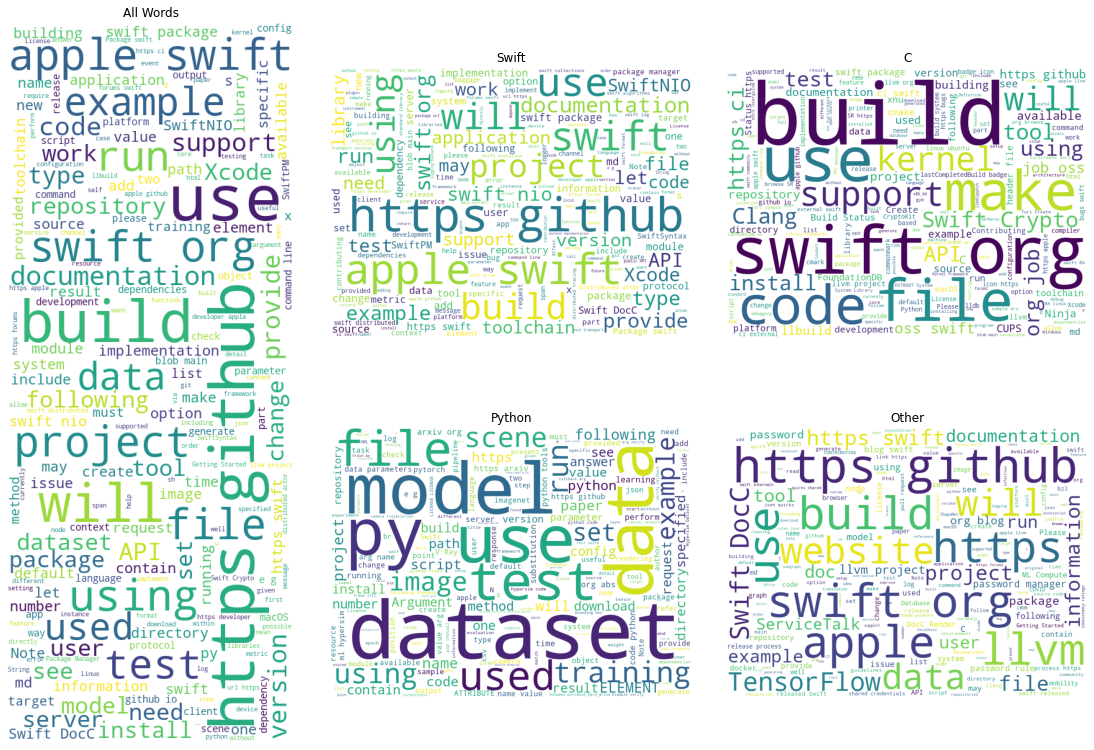

In [25]:
all_cloud = WordCloud(background_color = 'white', height = 1000, width = 400).generate(' '.join(All_Words))
swift_cloud = WordCloud(background_color = 'white', height = 600, width = 800).generate(' '.join(Swift_Words))
python_cloud = WordCloud(background_color = 'white', height = 600, width = 800).generate(' '.join(Python_Words))
c_cloud = WordCloud(background_color = 'white', height = 600, width = 800).generate(' '.join(C_Words))
other_cloud = WordCloud(background_color = 'white', height = 600, width = 800).generate(' '.join(Other_Words))

# Set size of figures
plt.figure(figsize = (10, 10))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5]), plt.axes([1.05, .5, .5, .5]),
      plt.axes([1.05, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(swift_cloud)
axs[2].imshow(python_cloud)
axs[3].imshow(c_cloud)
axs[4].imshow(other_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Swift')
axs[2].set_title('Python')
axs[3].set_title('C')
axs[4].set_title('Other')

for ax in axs: ax.axis('off')

In [54]:
# Creating Swift trigrams:
top_20_swift_trigrams = (pd.Series(nltk.ngrams(Swift_Words, 3))
                      .value_counts()
                      .head(20))

top_20_swift_trigrams.head()

(│, │, │)          103
(part, of, the)     32
(─, ─, ─)           31
(you, need, to)     22
(as, well, as)      22
dtype: int64

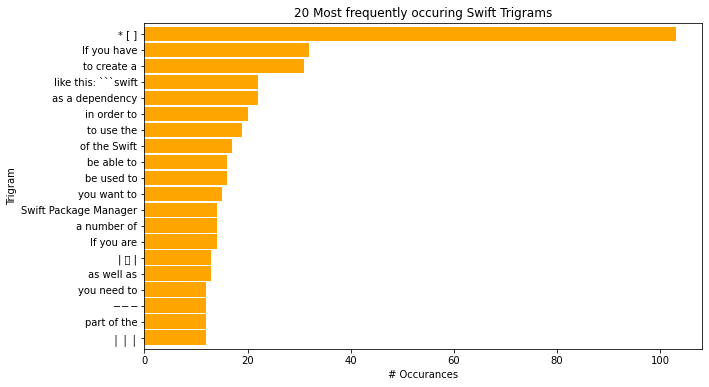

In [57]:
# Charting Swift trigrams:
top_20_swift_trigrams.sort_values().plot.barh(color='orange', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Swift Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_swift_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

In [52]:
# Creating Python trigrams:
top_20_python_trigrams = (pd.Series(nltk.ngrams(Python_Words, 3))
                      .value_counts()
                      .head(20))

top_20_python_trigrams.head()

(can, be, used)            29
(be, used, to)             19
(</arg>, </verify>, ##)    15
(}, ```, ##)               13
(|, 1, |)                  13
dtype: int64

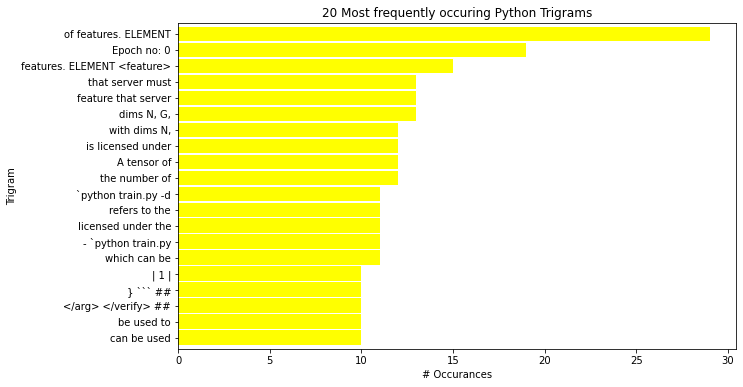

In [61]:
# Charting Python trigrams:
top_20_python_trigrams.sort_values().plot.barh(color='yellow', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

In [58]:
# Creating C trigrams:
top_20_c_trigrams = (pd.Series(nltk.ngrams(C_Words, 3))
                      .value_counts()
                      .head(20))

top_20_c_trigrams.head()

(-, [, ])          22
(│, │, ├)          21
(│, │, │)          17
(part, of, the)     9
(│, └, ...)         8
dtype: int64

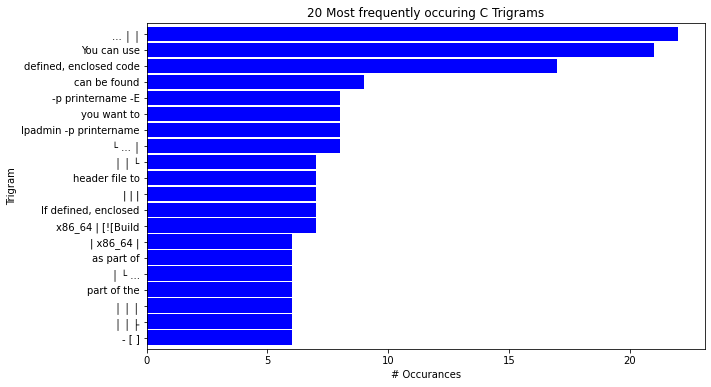

In [62]:
# Charting C trigrams:
top_20_c_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring C Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_c_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

In [63]:
# Creating the 'Other' trigrams:
top_20_other_trigrams = (pd.Series(nltk.ngrams(Other_Words, 3))
                      .value_counts()
                      .head(20))

top_20_other_trigrams.head()

(|, |, Swift)                13
(as, well, as)                8
(can, be, used)               6
(be, used, to)                5
(mobility, and, COVID-19)     5
dtype: int64

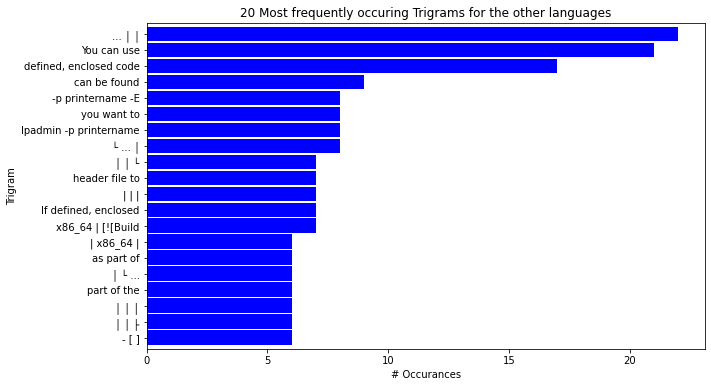

In [64]:
# Charting the 'Other' trigrams:
top_20_c_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Trigrams for the other languages')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_c_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

# Modeling
___


#### Logistic Regression:

In [26]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_prepped.original)
y = df_prepped.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train_lm = pd.DataFrame(dict(actual=y_train))
test_lm = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train_lm['predicted'] = lm.predict(X_train)
test_lm['predicted'] = lm.predict(X_test)

In [28]:
print('Accuracy: {:.2%}'.format(accuracy_score(train_lm.actual, train_lm.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_lm.predicted, train_lm.actual))
print('---')
print(classification_report(train_lm.actual, train_lm.predicted))

Accuracy: 84.68%
---
Confusion Matrix
actual      C  Other  Python  Swift
predicted                          
C          13      1       0      0
Python      0      3      29      0
Swift       5      7       1     52
---
              precision    recall  f1-score   support

           C       0.93      0.72      0.81        18
       Other       0.00      0.00      0.00        11
      Python       0.91      0.97      0.94        30
       Swift       0.80      1.00      0.89        52

    accuracy                           0.85       111
   macro avg       0.66      0.67      0.66       111
weighted avg       0.77      0.85      0.80       111



In [29]:
# baseline
df_prepped[df_prepped['language'] == 'Swift'].language.value_counts()/sum(df_prepped.language.value_counts())

Swift    0.467626
Name: language, dtype: float64

#### Decision Tree:

In [30]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_prepped.original)
y = df_prepped.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

dtc = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)

train['predicted'] = dtc.predict(X_train)
test['predicted'] = dtc.predict(X_test)

In [31]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 81.98%
---
Confusion Matrix
actual      C  Other  Python  Swift
predicted                          
C          13      4       2      1
Python      3      4      27      0
Swift       2      3       1     51
---
              precision    recall  f1-score   support

           C       0.65      0.72      0.68        18
       Other       0.00      0.00      0.00        11
      Python       0.79      0.90      0.84        30
       Swift       0.89      0.98      0.94        52

    accuracy                           0.82       111
   macro avg       0.58      0.65      0.62       111
weighted avg       0.74      0.82      0.78       111



#### Random Forest:

In [32]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_prepped.original)
y = df_prepped.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123).fit(X_train, y_train)

train['predicted'] = rf.predict(X_train)
test['predicted'] = rf.predict(X_test)

In [33]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 72.97%
---
Confusion Matrix
actual      C  Other  Python  Swift
predicted                          
C           2      0       0      0
Python      0      1      27      0
Swift      16     10       3     52
---
              precision    recall  f1-score   support

           C       1.00      0.11      0.20        18
       Other       0.00      0.00      0.00        11
      Python       0.96      0.90      0.93        30
       Swift       0.64      1.00      0.78        52

    accuracy                           0.73       111
   macro avg       0.65      0.50      0.48       111
weighted avg       0.72      0.73      0.65       111



#### K Nearest Neighbors:

In [34]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_prepped.original)
y = df_prepped.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

knn = KNeighborsClassifier(n_neighbors = 2).fit(X_train, y_train)

train['predicted'] = dtc.predict(X_train)
test['predicted'] = dtc.predict(X_test)

In [35]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 80.18%
---
Confusion Matrix
actual      C  Other  Python  Swift
predicted                          
C          11      4       2      1
Python      3      4      27      0
Swift       4      3       1     51
---
              precision    recall  f1-score   support

           C       0.61      0.61      0.61        18
       Other       0.00      0.00      0.00        11
      Python       0.79      0.90      0.84        30
       Swift       0.86      0.98      0.92        52

    accuracy                           0.80       111
   macro avg       0.57      0.62      0.59       111
weighted avg       0.72      0.80      0.76       111



### Logistic Regression with Cross Validation on the TEST SET:

In [41]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_prepped.original)
y = df_prepped.language

# We decided not to stratify because the sample is already balanced
# We also decided to split 70/30
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train_lm = pd.DataFrame(dict(actual=y_train))
test_lm = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train_lm['predicted'] = lm.predict(X_train)
test_lm['predicted'] = lm.predict(X_test)

In [42]:
print('Accuracy: {:.2%}'.format(accuracy_score(test_lm.actual, test_lm.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test_lm.predicted, test_lm.actual))
print('---')
print(classification_report(test_lm.actual, test_lm.predicted))

Accuracy: 78.57%
---
Confusion Matrix
actual     C  Other  Python  Swift
predicted                         
C          1      0       0      0
Python     1      1       8      0
Swift      2      2       0     13
---
              precision    recall  f1-score   support

           C       1.00      0.25      0.40         4
       Other       0.00      0.00      0.00         3
      Python       0.80      1.00      0.89         8
       Swift       0.76      1.00      0.87        13

    accuracy                           0.79        28
   macro avg       0.64      0.56      0.54        28
weighted avg       0.73      0.79      0.71        28



### Function that will take in the text of a README file, and makes a prediction of language:

In [45]:
def get_github_repo(url):
    """
    This function takes a url and returns a dictionary that
    contains the content and language of the readme file.
    """
    response = get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    readme = soup.find('div', id='readme')
    language = soup.find('span', class_='lang')
    
    d = dict()
    if readme is None:
        d['readme'] = 'No readme file.'
    else:
        d['readme'] = readme.text
    if language is None:
        d['language'] = 'No language specified.'
    else:
        d['language'] = language.text
    return d

In [48]:
def predict(unknown_text):
    return lm.predict(tfidf.transform([unknown_text]))[0]

In [51]:
# Plug in web address below to predict primary language of readme file:
corpus = get_github_repo('https://github.com/apple/swift-nio')['readme']
predict(corpus)

'Swift'